# Momemtum Assignment - Choi

### Import Packages

In [1]:
import wrds
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm

### WRDS Data

In [2]:
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [20]:
data = conn.raw_sql("""select*
                            
                            from crsp.msf_v2
                        
                            where ShareType = 'NS'
                            and SecurityType = 'EQTY'
                            and SecuritySubType = 'COM'
                            and USIncFlg = 'Y'
                            and IssuerType in ('ACOR', 'CORP')
                            and primaryexch in ('N','A', 'Q')
                            """, date_cols=['datadate'])

In [2]:
# data.to_pickle("./data.pkl") # Save data via pickle

### Summary statistics

In [2]:
data = pd.read_pickle("./data.pkl")
# from 1962 January to December 2023 
data_new = data[data['yyyymm'] >= 196201]

In [4]:
data_new_filtered = data_new.loc[
    (data_new['mthprevprc'] >= 5) & 
    (data_new['conditionaltype'] == 'RW') & 
    (data_new['tradingstatusflg'] == 'A')]

In [20]:
# Summary Statistics before filtering
print(round(data_new['mthret'].mean(),5))
print(round(data_new['mthret'].std(),5))
print(round(data_new['mthprevprc'].mean(),5))
print(round(data_new['mthprc'].median(),5))
print(round(data_new['mthprc'].std(),5))

0.01081
0.1857
38.43827
12.71
2140.47865


In [5]:
# Summary Statistics after filtering
print(round(data_new_filtered['mthret'].mean(),5))
print(round(data_new_filtered['mthret'].std(),5))
print(round(data_new_filtered['mthprevprc'].mean(),5))
print(round(data_new_filtered['mthprc'].median(),5))
print(round(data_new_filtered['mthprc'].std(),5))

0.00981
0.1347
50.65712
18.125
2477.33105


In [22]:
print(data_new.shape)
print(data_new_filtered.shape)

(3414845, 43)
(2538310, 43)


### Replicate Jegadeesh and Titman (1993)

In [23]:
def compute_momentum_ports(returns_matrix, eligibility_matrix, dates_vector, J=6, K=3):

    T, N = returns_matrix.shape  # T: number of time periods, N: number of stocks

    future_rets_all_strategies = np.full((T, K), np.nan) 

    # Loop over each row (time period) in the dataset
    for r in range(J + K, T):
        # For each of the K strategies, compute the past returns
        for k in range(K):
            lagged_rets = returns_matrix.iloc[r - J - k:r - k, :] 
            future_rets = returns_matrix.iloc[r, :]

            # Check eligibility matrix
            eligible_stocks = eligibility_matrix.iloc[r - k, :].astype(bool)

            # Filter out non-eligible stocks and calculate cumulative lagged returns
            valid_lagged_rets = lagged_rets.loc[:, eligible_stocks].dropna(axis=1, how='any')
            valid_future_rets = future_rets.loc[eligible_stocks].dropna()

            # If fewer than 10 stocks are eligible, skip this row
            if len(valid_lagged_rets.columns) < 10 or len(valid_future_rets) == 0:
                continue

            # Calculate cumulative past returns over the J-month lag period
            cumulative_lagged_returns = (1 + valid_lagged_rets).prod(axis=0) - 1

            # Sort stocks by their cumulative lagged returns
            sorted_stocks = cumulative_lagged_returns.sort_values()

            # Calculate the top and bottom 10% of stocks (deciles)
            num_stocks = len(sorted_stocks)
            top_decile_stocks = sorted_stocks.iloc[-num_stocks // 10:]  
            bottom_decile_stocks = sorted_stocks.iloc[:num_stocks // 10]

            # Ensure top and bottom decile stocks exist in valid_future_rets before calculating their mean
            valid_top_decile = top_decile_stocks.index.intersection(valid_future_rets.index)
            valid_bottom_decile = bottom_decile_stocks.index.intersection(valid_future_rets.index)

            # Calculate the average future returns for the valid top and bottom decile stocks
            if len(valid_top_decile) > 0 and len(valid_bottom_decile) > 0:
                top_ret = valid_future_rets.loc[valid_top_decile].mean()
                bottom_ret = valid_future_rets.loc[valid_bottom_decile].mean()
                future_rets_all_strategies[r, k] = top_ret - bottom_ret  # Long-short return for each strategy

    # Create a DataFrame to return the results for individual strategies
    strategies_df = pd.DataFrame(future_rets_all_strategies[J + K:], columns=[f'Strategy_{i+1}' for i in range(K)])
    strategies_df['Date'] = dates_vector[J + K:]  # Add date column

    # Create a DataFrame to return average results
    momentum_results = pd.DataFrame({
        'Date': dates_vector[J + K:], 
        'Momentum_Return': strategies_df.drop(columns=['Date']).mean(axis=1)  # Take the average across the K strategies
    })

    return momentum_results

In [24]:
# Data
data_q1 = data_new.loc[(data_new['yyyymm'] >= 196501) & (data_new['yyyymm'] <= 198912), ['permno','yyyymm','mthret','mthprevprc','tradingstatusflg','conditionaltype']].dropna()

# Apply price and status filters & Ensure the data is sorted by permno and yyyymm
data_q1_filtered = data_q1.loc[
    (data_q1['mthprevprc'] >= 5) & 
    (data_q1['conditionaltype'] == 'RW') & 
    (data_q1['tradingstatusflg'] == 'A')].sort_values(by=['permno', 'yyyymm'])

data_q1_filtered['date'] = pd.to_datetime(data_q1_filtered['yyyymm'].astype(str) + '01', format='%Y%m%d')

In [ ]:
# Eligibility matrix : 1 and 0 dummy variable for stocks that has been not traded 
# for example, if we have a specific stock in one portfolio selected by (6-month) cummulative return but if it went bankrupt and don't have any obs for our holding period K
# We do not have to include this stock in the original portfolio we constructed using lagged value

In [25]:
#  Prepare returns matrix 
returns_matrix = data_q1_filtered.pivot(index='date', columns='permno', values='mthret')
eligibility_matrix = pd.DataFrame(1, index=returns_matrix.index, columns=returns_matrix.columns)  # Assuming all stocks are eligible for now
dates_vector = returns_matrix.index  # List of dates corresponding to rows

# Compute the momentum strategy
momentum_results = compute_momentum_ports(returns_matrix, eligibility_matrix, dates_vector, J=1, K=1)

#### Returns for J-month/K-month strategy

In [29]:
# J and K values
J_values = [1, 3, 6, 9, 12]
K_values = [1, 3, 6, 9, 12]

# Prepare a DataFrame to store the results
results = []

# Loop over J and K combinations
for J in J_values:
    for K in K_values:
        # Compute the momentum strategy for each J/K combination
        momentum_results = compute_momentum_ports(returns_matrix, eligibility_matrix, dates_vector, J=J, K=K)
        
        # Calculate performance metrics
        avg_return = momentum_results['Momentum_Return'].mean()
        std_dev = momentum_results['Momentum_Return'].std()
        t_stat = avg_return / (std_dev / np.sqrt(len(momentum_results)))

        # Append the results
        results.append({
            'J': J,
            'K': K,
            'Average Return': avg_return,
            'Standard Deviation': std_dev,
            'T-Statistic': t_stat
        })

# Convert the results to a DataFrame for better display
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


     J   K  Average Return  Standard Deviation  T-Statistic
0    1   1       -0.014678            0.035427    -7.152366
1    1   3        0.000814            0.023652     0.591830
2    1   6        0.003835            0.019596     3.349928
3    1   9        0.004297            0.017117     4.275393
4    1  12        0.004992            0.014286     5.919868
5    3   1       -0.001580            0.042551    -0.638675
6    3   3        0.008473            0.036510     3.979388
7    3   6        0.009120            0.032313     4.814865
8    3   9        0.009099            0.027997     5.515356
9    3  12        0.008881            0.024305     6.168648
10   6   1        0.005787            0.048369     2.047851
11   6   3        0.012074            0.044320     4.647364
12   6   6        0.012568            0.039860     5.350782
13   6   9        0.012419            0.034730     6.037010
14   6  12        0.010336            0.031329     5.540115
15   9   1        0.008977            0.

### Extend the analysis to the most current data and find pre & post publication effects

In [16]:
# Extended dataset
data_q3 = data_new.loc[(data_new['yyyymm'] >= 196501), ['permno','yyyymm','mthret','mthprevprc','tradingstatusflg','conditionaltype']]
data_q3 = data_q3.dropna()

# Apply price and status filters & Ensure the data is sorted by permno and yyyymm
data_q3_filtered = data_q3.loc[
    (data_q3['mthprevprc'] >= 5) & 
    (data_q3['conditionaltype'] == 'RW') & 
    (data_q3['tradingstatusflg'] == 'A')].sort_values(by=['permno', 'yyyymm'])

data_q3_filtered['date'] = pd.to_datetime(data_q3_filtered['yyyymm'].astype(str) + '01', format='%Y%m%d')

In [17]:
#  Prepare returns matrix 
returns_matrix = data_q3_filtered.pivot(index='date', columns='permno', values='mthret')
eligibility_matrix = pd.DataFrame(1, index=returns_matrix.index, columns=returns_matrix.columns)  # Assuming all stocks are eligible for now
dates_vector = returns_matrix.index  # List of dates corresponding to rows

In [18]:
def plot_cumulative_returns(strategy_returns, label):
    cumulative_returns = (1 + strategy_returns['Momentum_Return']).cumprod() - 1
    plt.plot(momentum_results['Date'], cumulative_returns, label=label)

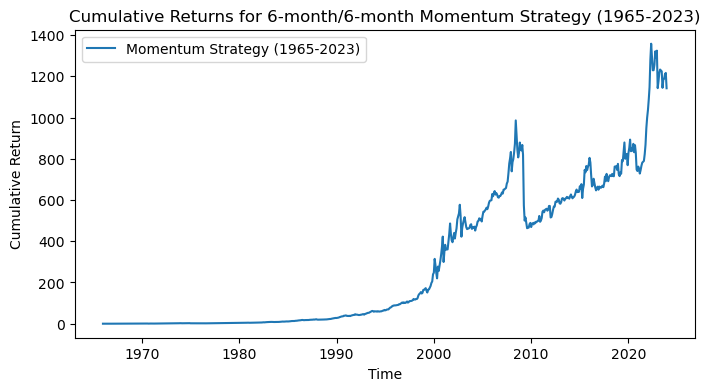

In [19]:
momentum_results = compute_momentum_ports(returns_matrix, eligibility_matrix, dates_vector, J=6, K=6)

# Plot the cumulative returns for the entire period (1965-2023)
plt.figure(figsize=(8, 4))
plot_cumulative_returns(momentum_results, 'Momentum Strategy (1965-2023)')
plt.title('Cumulative Returns for 6-month/6-month Momentum Strategy (1965-2023)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [20]:
# Pre Publication
pre_publication_data = data_q3_filtered[data_q3_filtered['date'].dt.year <= 1989]
returns_matrix = pre_publication_data.pivot(index='date', columns='permno', values='mthret')
eligibility_matrix = pd.DataFrame(1, index=returns_matrix.index, columns=returns_matrix.columns)  # Assuming all stocks are eligible for now
dates_vector = returns_matrix.index  # List of dates corresponding to rows

# Get the results
momentum_results = compute_momentum_ports(returns_matrix, eligibility_matrix, dates_vector, J=6, K=6)

# Statistics
avg_return = momentum_results['Momentum_Return'].mean()
std_dev = momentum_results['Momentum_Return'].std()
t_stat = avg_return / (std_dev / np.sqrt(len(momentum_results)))
print(avg_return)
print(std_dev)
print(t_stat)

0.01256768466083713
0.03985971996125076
5.350782226948631


In [21]:
# Post Publication
post_publication_data = data_q3_filtered[data_q3_filtered['date'].dt.year >= 1990]
returns_matrix = post_publication_data.pivot(index='date', columns='permno', values='mthret')
eligibility_matrix = pd.DataFrame(1, index=returns_matrix.index, columns=returns_matrix.columns)  # Assuming all stocks are eligible for now
dates_vector = returns_matrix.index  # List of dates corresponding to rows

# Get the results
momentum_results = compute_momentum_ports(returns_matrix, eligibility_matrix, dates_vector, J=6, K=6)

# Statistics
avg_return = momentum_results['Momentum_Return'].mean()
std_dev = momentum_results['Momentum_Return'].std()
t_stat = avg_return / (std_dev / np.sqrt(len(momentum_results)))
print(avg_return)
print(std_dev)
print(t_stat)

0.009868922815486273
0.05286825310305302
3.7146883593990676


### Does the CAPM beta or the Fama-French 3 factors explain any excess returns?

In [22]:
ff_data = pd.read_csv('F-F_Research_Data_Factors.csv')

In [23]:
ff_data.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [24]:
ff_data['date'] = pd.to_datetime(ff_data['Unnamed: 0'].astype(str) + '01', format='%Y%m%d')
momentum_returns = momentum_results[['Date', 'Momentum_Return']].copy()
ff_merged = pd.merge(momentum_returns, ff_data, left_on='Date', right_on='date')

ff_merged['Excess_Momentum_Return'] = ff_merged['Momentum_Return'] - ff_merged['RF'] / 100
ff_merged_clean = ff_merged.dropna(subset=['Excess_Momentum_Return', 'Mkt-RF', 'SMB', 'HML'])

In [25]:
# Excess Momentum Return ~ Mkt-RF
X_capm = sm.add_constant(ff_merged_clean['Mkt-RF'])
capm_model = sm.OLS(ff_merged_clean['Excess_Momentum_Return'], X_capm).fit()

print("CAPM Regression Results:")
print(capm_model.summary())

CAPM Regression Results:
                              OLS Regression Results                              
Dep. Variable:     Excess_Momentum_Return   R-squared:                       0.066
Model:                                OLS   Adj. R-squared:                  0.063
Method:                     Least Squares   F-statistic:                     27.62
Date:                    Sun, 20 Oct 2024   Prob (F-statistic):           2.42e-07
Time:                            18:31:54   Log-Likelihood:                 617.56
No. Observations:                     396   AIC:                            -1231.
Df Residuals:                         394   BIC:                            -1223.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [26]:
# Excess Momentum Return ~ (Mkt-RF, SMB, HML)
X_ff3 = sm.add_constant(ff_merged_clean[['Mkt-RF', 'SMB', 'HML']])
ff3_model = sm.OLS(ff_merged_clean['Excess_Momentum_Return'], X_ff3).fit()

print("\nFama-French 3-Factor Model Results:")
print(ff3_model.summary())


Fama-French 3-Factor Model Results:
                              OLS Regression Results                              
Dep. Variable:     Excess_Momentum_Return   R-squared:                       0.087
Model:                                OLS   Adj. R-squared:                  0.080
Method:                     Least Squares   F-statistic:                     12.51
Date:                    Sun, 20 Oct 2024   Prob (F-statistic):           7.90e-08
Time:                            18:31:54   Log-Likelihood:                 622.25
No. Observations:                     396   AIC:                            -1236.
Df Residuals:                         392   BIC:                            -1221.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

### Performance over longer periods

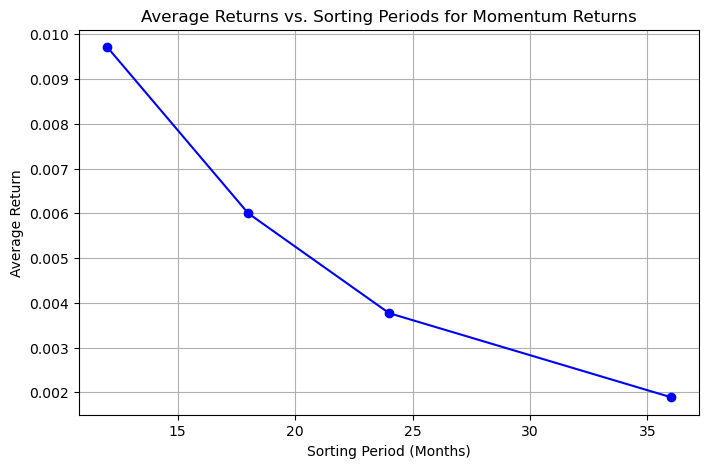

In [41]:
J_values = [12, 18, 24, 36]
K = 6  

average_returns = []
std_deviation = []
t_statistics = []

returns_matrix = data_q3_filtered.pivot(index='date', columns='permno', values='mthret')
eligibility_matrix = pd.DataFrame(1, index=returns_matrix.index, columns=returns_matrix.columns) 
dates_vector = returns_matrix.index 

for J in J_values:
    momentum_results = compute_momentum_ports(returns_matrix, eligibility_matrix, dates_vector, J=J, K=K)
    avg_return = momentum_results['Momentum_Return'].mean()
    std_dev = momentum_results['Momentum_Return'].std()
    t_stat = avg_return / (std_dev / np.sqrt(len(momentum_results)))
    average_returns.append(avg_return)
    std_deviation.append(std_dev)
    t_statistics.append(t_stat)

plt.figure(figsize=(8, 5))
plt.plot(J_values, average_returns, marker='o', linestyle='-', color='b')
plt.title('Average Returns vs. Sorting Periods for Momentum Returns')
plt.xlabel('Sorting Period (Months)')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()


In [43]:
results_df = pd.DataFrame({
    'J (Months)': J_values,
    'Average Return': average_returns,
    'Standard Deviation': std_deviation,
    't-statistics' : t_statistics
})

# Display the DataFrame
print(results_df)

   J (Months)  Average Return  Standard Deviation  t-statistics
0          12        0.009712            0.050407      5.061024
1          18        0.005999            0.049565      3.165536
2          24        0.003768            0.047979      2.044670
3          36        0.001889            0.044495      1.095670


### Seasonal Patterns

In [28]:
momentum_returns = momentum_results[['Date', 'Momentum_Return']].copy()

# Extract the month from the 'Date' column
momentum_returns['month'] = momentum_returns['Date'].dt.month

# Create dummy variables for each calendar month
month_dummies = pd.get_dummies(momentum_returns['month'], prefix='month', drop_first=False)

# Prepare the data for regression (momentum returns as dependent variable and month dummies as independent variables)
X = month_dummies
y = momentum_returns['Momentum_Return']

# Run the regression without a constant (since we are including all month indicators)
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

# Extract the average returns (coefficients) and t-statistics for each month
average_returns_by_month = model.params
t_stats_by_month = model.tvalues

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    'Average Return': average_returns_by_month.values,
    'T-Statistic': t_stats_by_month.values
})

# Display the results by calendar month
print(results_df)


                            OLS Regression Results                            
Dep. Variable:        Momentum_Return   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     5.456
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           2.36e-08
Time:                        18:32:49   Log-Likelihood:                 1157.6
No. Observations:                 666   AIC:                            -2291.
Df Residuals:                     654   BIC:                            -2237.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
month_1       -0.0359      0.006     -6.200      0.0